## $A_s$ constraints with the correlation coefficient

The correlation coefficient, defined with a ratio of the power spectra : $\mathcal{R}_\ell^{TE} = C_\ell^{TE} / \sqrt{C_\ell^{TT}C_\ell^{EE}}$ is unsensitive to the $A_s$ parameter which acts as an amplitude on the power spectra.

In [1]:
import getdist.plots as gdplt
import matplotlib as mpl
import matplotlib.pyplot as plt
import camb
from camb import model, initialpower
from getdist.mcsamples import loadMCSamples
import numpy as np
%matplotlib inline

cosmo = ['H0', 'ombh2', 'omch2', 'logA', 'ns', 'tau']
fg = ['Aradio', 'Adusty', 'AdustTT', 'AdustTP', 'AdustPP', 'Asz', 'Acib', 'Aksz', 'Aszxcib']

# TOOL
def plot_chains(datasets, labels, wanted, filled = True, verb=False):
        
    samples = [loadMCSamples(element, settings = {'ignore_rows': 0.5}) for element in datasets]
    
    lims = [[60, 75], [0.02, 0.025], [0.10, 0.13], [2.5, 3.5], [0.9,1.2], [0.04,0.07]]
    for i, label in enumerate(labels):
        print("R-1 ({}) : {}".format(label, samples[i].getGelmanRubin())) 
       
    gdplot = gdplt.get_subplot_plotter(width_inch=12)
    gdplot.settings.legend_fontsize = 20
    gdplot.settings.axes_fontsize = 15
    gdplot.settings.lab_fontsize = 20
    gdplot.settings.legend_loc = 'upper right'
    gdplot.triangle_plot(samples, wanted, filled = filled, legend_labels = labels)

In [2]:
def get_spectra(As, Alens, tau):

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=tau, Alens = Alens)
    pars.InitPower.set_params(As=As, ns=0.965, r=0)
    pars.set_for_lmax(2500, lens_potential_accuracy=0)
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
    
    totCL=powers['total']
    unlensedCL=powers['unlensed_scalar']

    TT = totCL[:, 0][2:]
    TTlens = unlensedCL[:, 0][2:]
    
    EE = totCL[:, 1][2:]
    EElens = unlensedCL[:, 1][2:]
    
    TE = totCL[:, 3][2:]
    TElens = unlensedCL[:, 3][2:]
    
    ls = np.arange(totCL.shape[0])[2:]
    
    R = TE/np.sqrt(TT*EE)
    Rlens = TElens/np.sqrt(TTlens*EElens)
    
    return(ls, R, Rlens)

### Variation of $\mathcal{R}$ with $A_s$

The unlensed correlation coefficient is not affected by $A_s$ (as shown in the figure below). However, $A_s$ acts on the lensing power spectrum, and then the correlation coefficient is able to constrain $A_s$ with the lensing.

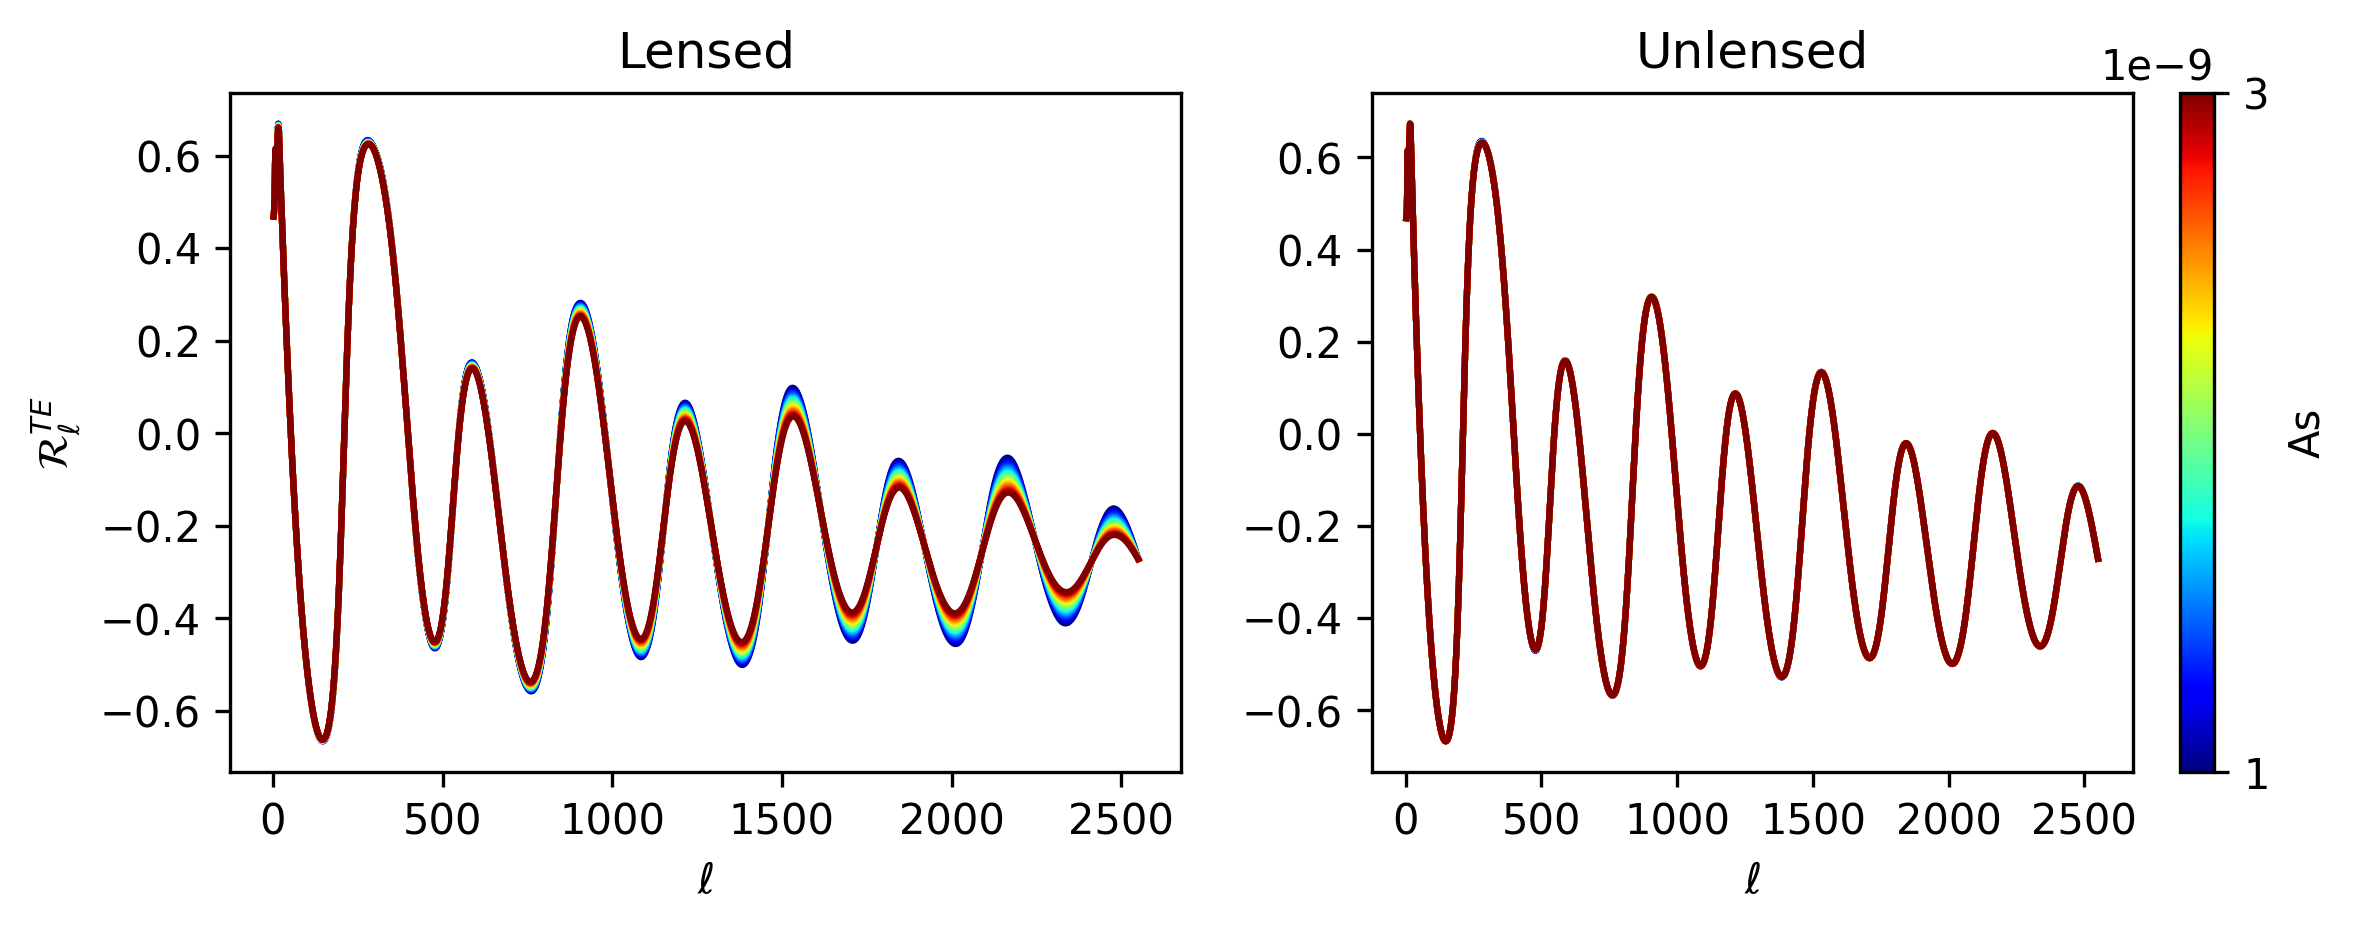

In [5]:
As = np.linspace(1e-9, 3e-9, 20)
c = np.linspace(0, 1, 10)
R_L = []
R_L_lens = []
for param in As:
    ls, R, Rlens = get_spectra(As = param, Alens = 1, tau = 0.0566)
    R_L.append(R)
    R_L_lens.append(Rlens)
R_L = np.array(R_L)
R_L_lens = np.array(R_L_lens)

norm = mpl.colors.Normalize(vmin=As.min(), vmax=As.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.jet)
cmap.set_array([])
fig,ax = plt.subplots(1, 2, figsize = (9,3), dpi = 300)
for i, yi in enumerate(R_L):
    ax[0].plot(ls, yi, c=cmap.to_rgba(As[i]))
    ax[0].set_title("Lensed")
    ax[0].set_ylabel(r"$\mathcal{R}_\ell^{TE}$")
    ax[0].set_xlabel(r"$\ell$")
    ax[1].plot(ls, R_L_lens[i], c=cmap.to_rgba(As[i]))
    ax[1].set_title("Unlensed")
    ax[1].set_xlabel(r"$\ell$")
fig.colorbar(cmap, ticks = [As[0], As[-1]], label = "As")
plt.show()

Due to this, the two parameters $A_s$ and $A_\mathrm{lens}$ have a strong correlation (~1) using $\mathcal{R}$ to constrain parameters from the data.

### Constraints for [$\Lambda$CDM + $A_\mathrm{lens}$] with $\mathcal{R}_\ell^{TE}$

R-1 (Hillipop $\mathcal{R}_\ell^{TE}$ + $\tau$-prior [$\Lambda$CDM + $A_\mathrm{lens}$]) : 0.007649384159378776


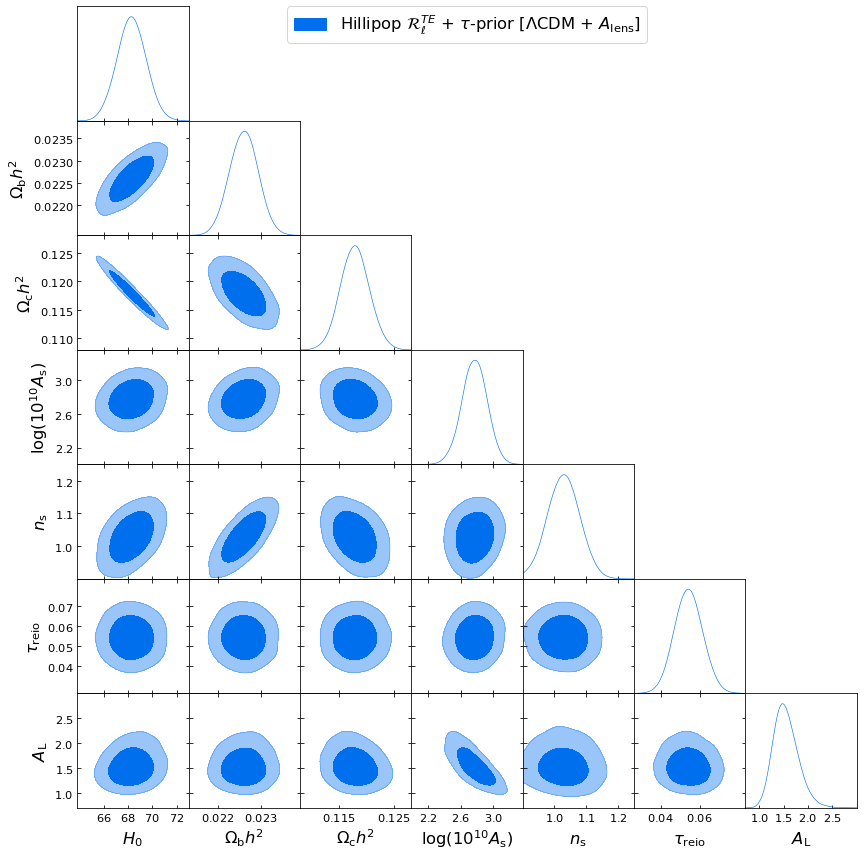

In [7]:
datasets = ['/home/adrien/Documents/workspace/hillipop/chains/RTE30_nocal/mcmc']
labels = [r'Hillipop $\mathcal{R}_\ell^{TE}$ + $\tau$-prior [$\Lambda$CDM + $A_\mathrm{lens}$]']
plot_chains(datasets, labels, cosmo + ['Alens'], filled = True, verb = True)

The correlation between $\mathrm{log}(10^{10}A_S)$ and $A_\mathrm{lens}$ appears to be strong (c.f. the correlation matrix plotted below). This correlation is around -0.75.

Correlation between As/Alens :  -0.7446998654572806


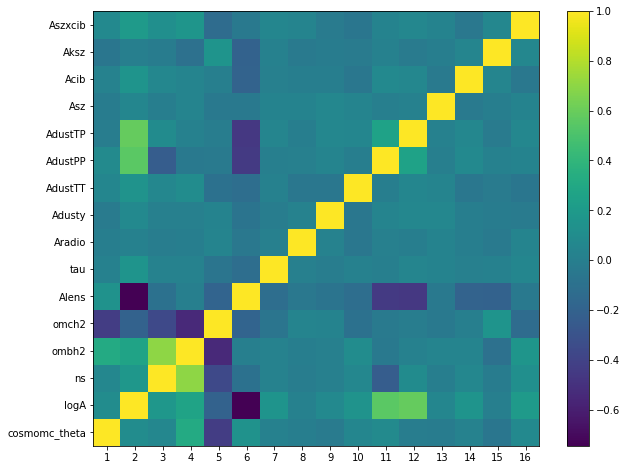

In [10]:
from getdist.covmat import CovMat
cov = CovMat("/home/adrien/Documents/workspace/hillipop/chains/RTE30_nocal/mcmc.1.covmat")
plt.figure(figsize=(10,8))
print("Correlation between As/Alens : ", cov.correlation()[1,5])
cov.plot()

The other interesting correlation displayed in the correlation matrix is the correlation between $A_s$/$A_\mathrm{lens}$ and some foregrounds parameters : AdustPP, and AdustTP. For previous figures, we used some gaussian priors for the foregrounds parameters. In the following, we will remove these very constraining priors, in order to use wide flat priors.

R-1 (Hillipop $\mathcal{R}_\ell^{TE}$ + $\tau$-prior [$\Lambda$CDM + $A_\mathrm{lens}$] + wide priors) : 0.01968664267098151


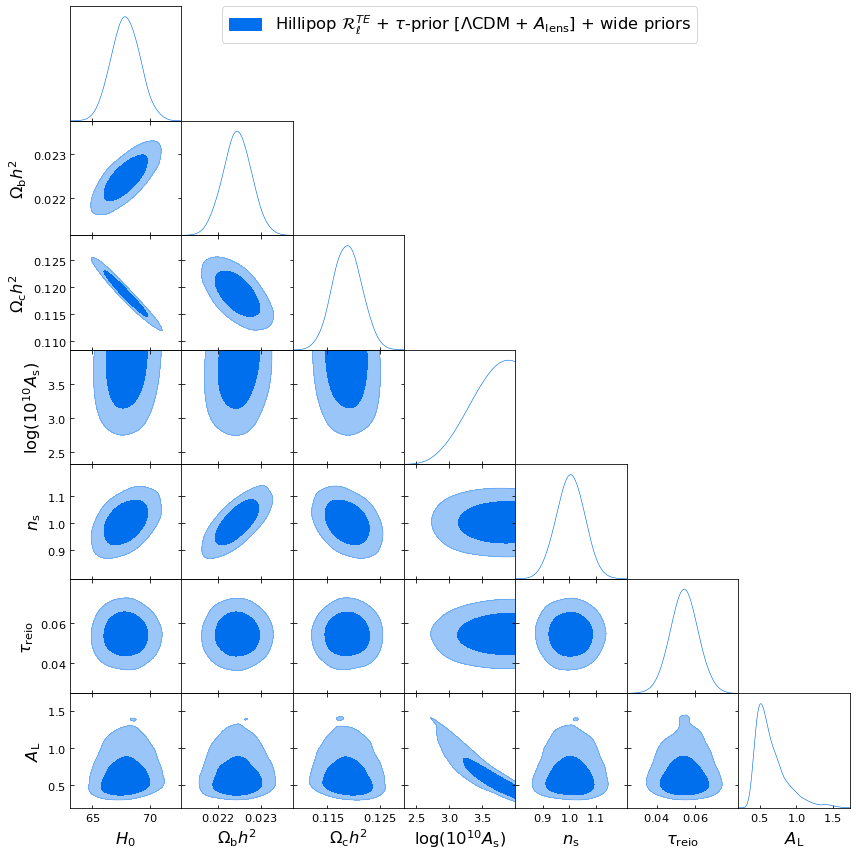

In [11]:
datasets = ['/home/adrien/Documents/workspace/hillipop/chains/RTE30_nocal_wppp/mcmc']
labels = [r'Hillipop $\mathcal{R}_\ell^{TE}$ + $\tau$-prior [$\Lambda$CDM + $A_\mathrm{lens}$] + wide priors']
plot_chains(datasets, labels, cosmo + ['Alens'], filled = True, verb = True)

Correlation between As/Alens :  -0.9039629447933867


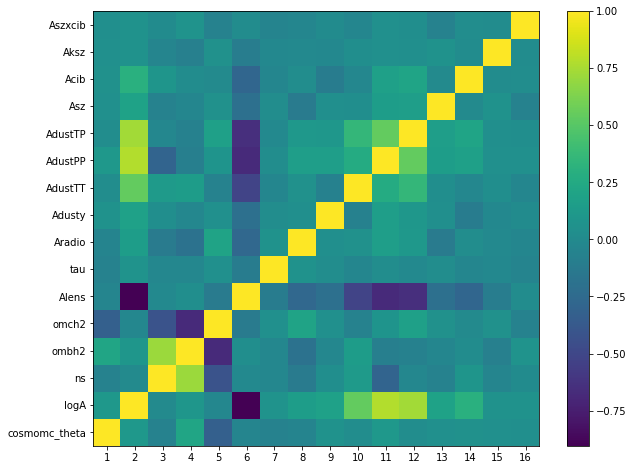

In [12]:
cov = CovMat("/home/adrien/Documents/workspace/hillipop/chains/RTE30_nocal_wppp/mcmc.1.covmat")
plt.figure(figsize=(10,8))
print("Correlation between As/Alens : ", cov.correlation()[1,5])
cov.plot()

Previous figures show that foregrounds priors have a strong influence on the $A_s$ parameter determination. The baseline to use for correlation coefficient analysis is to set $A_{\mathrm{lens}} = 1$, and to use wide foregrounds priors (in order to minimize the bias induced on the $A_s$ measurement by the foregrounds)